In [32]:
# Authors: Stylianos Kampakis & Shreesha Jagadeesh

### Purpose

This is the full solution for Project 1 until the end of Milestone 4 for Novelty Detection using Isolation Forest

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)

1. [Initialization](#2)
    1. [Load packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data](#3)

1. [Data Insights](#4)
    1. [Data Structure](#41)
    1. [Summary Stats](#42)
    1. [Unique Value Checking](#43)
    1. [Identifying 'Bad Columns'](#44)

1. [Data Cleansing](#5)
    1. [Data Reduction](#51)
        1. [Dropping Bad Columns](#511)
        1. [Null Value Removal](#512)
        1. [Data Encoding](#513)
    1. [Export csv file for later use](#52)

1. [Modelling Workflow](#6)
    1. [Data Prep](#61)
        1. [Feature Target Split](#611)
        1. [Train-Test Split](#612)
        1. [Normalizing Numerical Variables](#613)
    1. [Estimate of Baseline Accuracy - Class Distributions](#62)
    1. [Semisupervised & Unsupervised Techniques for Novelty & Outlier Detection](#63)
        1. [OneClassSVMs for Novelty Detection](#631)
        1. [Robust Covariance for Outlier Detection](#632)
        1. [Isolation Forest for Novelty Detection](#633)
        1. [Local Outlier Factor for Novelty Detection](#634)


# <a id='1'>Introduction</a>  

As described on the project page, the dataset contains the Thyroid disease data that is imbalanced. Before running this notebook, please make sure that you have gone through the first project in the LiveSeries and the starter template

## <a id='2'>Initialization</a>  


### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [33]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy.io.arff import loadarff
import scipy.io as sio

from collections import Counter
from sklearn.preprocessing import MinMaxScaler

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.metrics import accuracy_score, classification_report,confusion_matrix 
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, average_precision_score

### <a id='22'>Define Metadata</a>  

In [34]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 6

# Fill in the names of what you want to call the 0 and 1 class
labels = ['inliers', 'outliers']

# The following file is downloaded from http://odds.cs.stonybrook.edu/thyroid-disease-dataset/ and kept in the data/raw folder
input_file_name = 'thyroid.mat'

# Using relative path path to specify that the data subfolder is two directories up from the current folder 
raw_data_folder = '../01-Data/Raw/'
processed_data_folder = '../01-Data/Processed/'

# Any exported artifacts will have this date
export_date = '20211101'

## <a id='3'>Load Data</a>  

In this part we will load the data and perform some necessary preprocessing

In [35]:
data=sio.loadmat(raw_data_folder + input_file_name)

data
# This is an interesting format with the metadata available as header, version and globals while the features are given 
# in the X array and the y 

# There appears to be 6 attributes in X, all numerical 
# The y values seems to be already encoded as numbers too

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-05 13:11:25 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[7.74193548e-01, 1.13207547e-03, 1.37571157e-01, 2.75700935e-01,
         2.95774648e-01, 2.36065574e-01],
        [2.47311828e-01, 4.71698113e-04, 2.79886148e-01, 3.29439252e-01,
         5.35211268e-01, 1.73770492e-01],
        [4.94623656e-01, 3.58490566e-03, 2.22960152e-01, 2.33644860e-01,
         5.25821596e-01, 1.24590164e-01],
        ...,
        [9.35483871e-01, 2.45283019e-02, 1.60341556e-01, 2.82710280e-01,
         3.75586854e-01, 2.00000000e-01],
        [6.77419355e-01, 1.47169811e-03, 1.90702087e-01, 2.42990654e-01,
         3.23943662e-01, 1.95081967e-01],
        [4.83870968e-01, 3.56603774e-03, 1.90702087e-01, 2.12616822e-01,
         3.38028169e-01, 1.63934426e-01]]),
 'y': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])}

In [36]:
# Store the features and target objects in their own variables for easy retreival
X=data['X']
y=data['y']

X.shape, y.shape

((3772, 6), (3772, 1))

In [37]:
# Convert to a dataframe
df=pd.DataFrame((np.concatenate((X, y), axis=1)))

# Take a random sample to see how the data looks like
df.sample(5)

,0,1,2,3,4,5,6
1071,0.827957,0.001321,0.137571,0.200935,0.319249,0.162295,0.0
165,0.720430,0.003019,0.232448,0.226636,0.422535,0.144262,0.0
2249,0.698925,0.003774,0.190702,0.308411,0.370892,0.221311,0.0
2222,0.268817,0.005094,0.260911,0.219626,0.295775,0.190164,0.0
773,0.591398,0.000377,0.232448,0.317757,0.450704,0.191803,0.0


Lets check the head & tail to make sure there is nothing going on at the last row or the header

In [38]:
df.head(3)

,0,1,2,3,4,5,6
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,0.0
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,0.0
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,0.0


In [39]:
df.tail(3)

,0,1,2,3,4,5,6
3769,0.935484,0.024528,0.160342,0.282710,0.375587,0.200000,0.0
3770,0.677419,0.001472,0.190702,0.242991,0.323944,0.195082,0.0
3771,0.483871,0.003566,0.190702,0.212617,0.338028,0.163934,0.0


No trouble with loading the data. Both the head and tail are clean

## <a id=4 > Data Insights

### <a id='41'>Data Structure</a> 

In [40]:
# Lets see the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3772 non-null   float64
 1   1       3772 non-null   float64
 2   2       3772 non-null   float64
 3   3       3772 non-null   float64
 4   4       3772 non-null   float64
 5   5       3772 non-null   float64
 6   6       3772 non-null   float64
dtypes: float64(7)
memory usage: 206.4 KB


None of the columns have null values at first glance, but we will run a more thorough diagnostic later

### <a id='42'>Summary Stats</a> 

check out each column's summary statistics
Note that only the numerical columns will be described
Also you will want to exclude the discrete columns whose summary stats will give non-sensical values like 'customer_id' 

In [41]:
df.describe()
# Looks like all the numbers are between 0 and 1

,0,1,2,3,4,5,6
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,0.543121,0.008983,0.186826,0.248332,0.376941,0.177301,0.024655
std,0.203790,0.043978,0.070405,0.080579,0.087382,0.054907,0.155093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.376344,0.001132,0.156546,0.203271,0.328638,0.149180,0.000000
50%,0.569892,0.003019,0.190702,0.241822,0.375587,0.173770,0.000000
75%,0.709677,0.004528,0.213472,0.282710,0.413146,0.196721,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <a id='43'>Unique Value Checking</a> 

In [42]:
for column in df.columns:
    print(column, len(df[column].unique()))

0 93
1 280
2 72
3 243
4 141
5 324
6 2


All of the columns have atleast 2 unique values, hence there is less of a chance of quasi-constant values 

### <a id='44'>Identifying Bad Columns</a> 

In [43]:
def find_bad_columns_function(dataframe):
    '''
    Args: dataframe for which there maybe columns of concern that need to be fixed or deleted
    
    Logic: Find the columns that have 
    Null values
    blanks in the strings
    quasi constant/constant values defined by less than 1% variance
    
    Returns: 4 lists containing those features that have nulls, blanks, constant values throughout for numerical and categorical
    
    '''
    
    ###### Finding Null Values
    null_col_list = dataframe.columns[dataframe.isna().any()].tolist()
    
    print('Identified {} features with atleast one null'.format(
        len(null_col_list)))

    ###### Finding Blank Spaces in the object column
    # Non-obvious nulls such as blanks: The line items where there are spaces 
    blank_space_col_list = []
    object_columns = dataframe.select_dtypes(include=['object']).columns

    for col in object_columns:
        if sum(dataframe[col]==' '):
            blank_space_col_list.append(col)

    print('Identified {} features with atleast one blank space'.format(
        len(blank_space_col_list)))
    
    ####### Finding Quasi Constant/Constant Value in numerical columns
    # Lets remove the variables that have more than 99% of their values as the same 
    # ie their standard deviation is less than 1 %
    
    numeric_df = dataframe._get_numeric_data()
    constant_numeric_col_list = [col for col in numeric_df.columns if numeric_df[col].std()<0.01]

    print('Identified {} numeric features that have quasi-constant values'.format(
        len(constant_numeric_col_list)))
    
    # We use a separate logic for the non-numerical variables because if you have closely varying float values
    # then the below code snippet wont pick it up
    
    ###### Finding Quasi Constant/Constant non_numeric value
    constant_non_numeric_col_list = []
    
    # Find the columns that are not in numeric_df
    non_numeric_col_set = set(dataframe.columns) - set(numeric_df.columns)   

    for col in non_numeric_col_set:
        categorical_mode_value = (dataframe[col].mode().values)[0]
        fractional_presence = sum(dataframe[col]==categorical_mode_value)/len(dataframe) 
    
        if fractional_presence > 0.99:
            constant_non_numeric_col_list.append(col)
            
    print('Identified {} non-numeric features that have quasi-constant values'.format(
        len(constant_non_numeric_col_list)))
    
    return null_col_list, blank_space_col_list, constant_numeric_col_list, constant_non_numeric_col_list

In [44]:
# use the above custom function to figure out the if there are any columns we need to be concerned about
null_col_list, blank_space_col_list, constant_numeric_col_list, \
constant_non_numeric_col_list = find_bad_columns_function(df)

Identified 0 features with atleast one null
Identified 0 features with atleast one blank space
Identified 0 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values


Thankfully, there is no need to worry about any of the columns in this dataset

## <a id='5'>Data Cleansing</a> 

### <a id='51'>Data Reduction</a> 

#### <a id='511'>Dropping Bad Columns</a> 

In [45]:
# Skip this because there are no columns

#### <a id='512'>Null Value Removal</a> 

In [46]:
# No null values to drop from the rows

#### <a id='513'>Data Encoding</a> 

In [47]:
df.dtypes

0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
dtype: object

In [48]:
# There are no categorical variables to encode 

### <a id='52'>Export cleaned csv file for later use</a> 

In [49]:
# have a backup copy of the processed dataframe 
# so that you don't need to run the entire notebook again just to get to the next stage

cleaned_dataframe_name='cleaned_thryoid_dataframe'
df.to_csv(processed_data_folder + cleaned_dataframe_name + export_date + '.csv', index=False)


## Milestone 1 Ends

## Milestone 2 Begins

## <a id = 6 > Modelling Workflow

### <a id = 61 > Data Prep 

#### <a id='611'>Feature - Target Split</a> 

In [50]:
# Display dataframe structure
df

,0,1,2,3,4,5,6
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,0.0
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,0.0
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,0.0
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,0.0
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,0.0
...,...,...,...,...,...,...,...
3767,0.817204,0.000113,0.190702,0.287383,0.413146,0.188525,0.0
3768,0.430108,0.002453,0.232448,0.287383,0.446009,0.175410,0.0
3769,0.935484,0.024528,0.160342,0.282710,0.375587,0.200000,0.0
3770,0.677419,0.001472,0.190702,0.242991,0.323944,0.195082,0.0


In [51]:
X = df.drop(target_class_name, axis=1)
y = df[target_class_name]

print(X.shape )
X

(3772, 6)


,0,1,2,3,4,5
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541
...,...,...,...,...,...,...
3767,0.817204,0.000113,0.190702,0.287383,0.413146,0.188525
3768,0.430108,0.002453,0.232448,0.287383,0.446009,0.175410
3769,0.935484,0.024528,0.160342,0.282710,0.375587,0.200000
3770,0.677419,0.001472,0.190702,0.242991,0.323944,0.195082


In [52]:
print("\n", y.shape )
y


 (3772,)


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3767    0.0
3768    0.0
3769    0.0
3770    0.0
3771    0.0
Name: 6, Length: 3772, dtype: float64

#### <a id='612'>Train-Test Split</a> 

In [53]:
# split into train and test set and 
# make sure that the stratification is done so that roughly proportional instances of the minority class is present in the train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# These are the original dimensions and the outlier class occurrences 
print(X_train.shape, X_test.shape, sum(y_train==1), sum(y_test==1))


(3017, 6) (755, 6) 74 19


#### <a id = 613 > Normalizing numerical variables

In [54]:
# This is not needed here because the variables are already scaled between 0 and 1

### <a id='62'>Estimate of baseline accuracy - Class Distributions </a> 

In [55]:
# Figure out the class distribution percentage and round it to 3 decimal places

print('Percentage of inliers is {} %'.format(
    round(df[target_class_name].value_counts()[0]/len(df) * 100,3)))

print('Percentage of outliers is {} %'.format(
    round(df[target_class_name].value_counts()[1]/len(df) * 100,3)))

# A dumb model that predicts everything as being 0, will generate a baseline accuracy of 97.5%

Percentage of inliers is 97.534 %
Percentage of outliers is 2.466 %


/tmp/ipykernel_4447/729827319.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df[target_class_name]).plot.bar()


6
0.0    3679
1.0      93
Name: count, dtype: int64

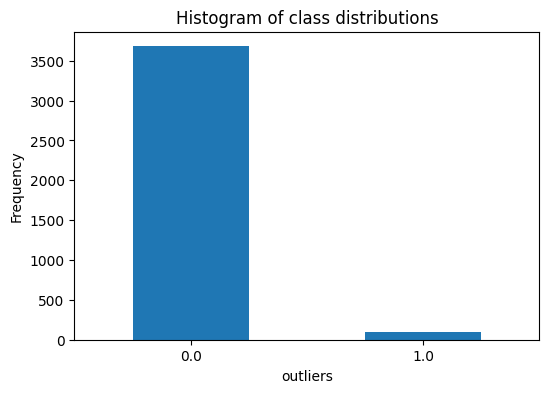

In [56]:
plt.figure(figsize=(6,4))
pd.value_counts(df[target_class_name]).plot.bar()
plt.title('Histogram of class distributions')
plt.xlabel(labels[1])
plt.xticks(rotation=0)
plt.ylabel('Frequency')
df[target_class_name].value_counts()

The baseline accuracy to beat is 97.5% if you predict everything as being 0 (i.e. the majority class)

What about the other metrics like Precision, Recall and F1 score? They would all be 0% because there will be no True Positives 

In [57]:
#This is the number of outliers that we observe in the overall dataset. 
outliers_fraction=0.025

#We will use a multiple of this as the nu or contamination factor to tell the model how many to expect

### <a id='63'> Scikit Learn Algorithms for Novelty & Outlier Detection </a> 

#### Q. Why do we need specialized techniques for Anomaly Detection rather than just use binary classification algorithms?

Compared to binary classification problems, the minority class, i.e. the anomalies, are quite rare and often different from each other. So the usual binary classification algorithms fail to 'learn' a representation of the minority class. We will attempt to use binary classification methdods with resampling techniques that balance out the distributions of the 2 classes in projects 2 & 3 but in this Project we will focus on out-of-the-box Anomaly detection algorithms provided by Scikit Learn

The previous plot of class distributions gave an indication of how rare our samples are and this warrants these special techniques

#### Difference between Novelty, Outliers and Anomalies

In many use cases, the differences between them are irrelevant. As long as the sample is 'sufficiently' different, we can call them whatever we want. However there are specialized use cases where huge performance gains can be achieved by using a semi-supervised technique of Novelty Detection vs completely unsupervised Outlier Detection. Hence it is important to understand what the differences are

Novelty Detection: The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty. This would mean that our input train data during model fitting cannot contain the minority class. 

Outlier Detection: The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

Both Novelties and Outlier samples are referred to as the Anomalies

Further details are in the sklearn documentation page
https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

In the following milestones, we will explore applying both types of algorithms on our training dataset.  

#### <a id='631'>OneClassSVMs for Novelty Detection</a> 

#### Introduction to semi-supervised approaches

The main problem solved by OneClassSVM is for novelty detection using an semi-supervised approach

As Leo Tolstoy said ‘All happy families are alike; each unhappy family is unhappy in its own way.’
The implication for our use case is that OneClassSVM excels in situations where the inliers are all alike but the outliers are all special snowflakes. Datasets that have such as issue prevents the use of traditional 2-class binary classification problems and instead we use a 'unary' classification problem. Only the statistics of normal operation are known from the inliers

*We will be using OneClassSVM in a similar manner as unsupervised clustering. The approach processes the data as a static
distribution, pinpoints the most remote points, and flags them as potential outliers.* 

**The main assumption on the data is that the outliers are actually separated from the inliers and hence the OCSVM algorithm can indeed separate it out.** 

The main thing to note is that *deleting the minority class from the input train data improves the performance when the model later sees the outliers mixed in* with normal inliers. This would be a case of semi-supervised because we are using the labels but not necessarily to fit the model but to remove the minority class samples to improve the performance

#### Reference


https://proceedings.neurips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf

https://en.wikipedia.org/wiki/One-class_classification

https://eprints.whiterose.ac.uk/767/1/hodgevj4.pdf

https://www.datatechnotes.com/2020/04/anomaly-detection-with-one-class-svm.html

#### Define function to hold the binary classification metrics

In [58]:
# Reuse the same function from the starter template
def custom_classification_metrics_function(X_test, y_test, labels, classifier):
    '''
    Args: The features and the target column; the labels are the categories, sklearn classifier object
    Calculates Classification metrics of interest
    Returns: A dictionary containing the classification metrics
    '''

    # Generate the predictions on the test data which forms the basis of the evaluation metrics
    test_pred = classifier.predict(X_test)
        
    # This is to convert the output labels so that the confusion matrix and the accuracy scores work correctly
    # The anomalies identified by sklearn are labelled as -1 but we want them to recognized as 1, so we flip the labels
    test_pred = test_pred*-1
    test_pred[test_pred==-1]=0
    
    ### Classification report
    print(classification_report(y_test, test_pred, target_names=labels))

    ### Probability scores
    
    # Unlike the usual classifiers, Anomaly detection algorithms don't have a predict_proba() method that can be applied
    # Instead we have to get the raw scores from the decision function applied on the test data
    decision_score_list = classifier.decision_function(X_test)
    
    # ......and turn them into numbers between 0 and 1 which can be treated as probabilities
    scaled_decision_score_list = MinMaxScaler().fit_transform(decision_score_list.reshape(-1, 1))

    # This is just to flatten the list and subtract the no.s so that the outliers are closer to 1 rather than 0
    y_scores = [1-item for sublist in scaled_decision_score_list for item in sublist]


    ### Confusion Matrix
    confusion_matrix_test_object = confusion_matrix(y_test, test_pred)
                
    # Initialize a dictionary to store the metrics we are interested in
    metrics_dict = Counter()

    # These are all the basic threshold-dependent metrics
    metrics_dict['Accuracy']  = float("{0:.4f}".format(accuracy_score(y_test, test_pred)))

    # The following are more useful than the accuracy
    metrics_dict['Precision'] = float("{0:.4f}".format(precision_score(y_test, test_pred, average='macro')))
    metrics_dict['Recall'] = float("{0:.4f}".format(recall_score(y_test, test_pred, average='macro')))
    metrics_dict['F1'] = float("{0:.4f}".format(f1_score(y_test, test_pred, average='macro')))

    metrics_dict['TN'] = confusion_matrix_test_object[0][0]
    metrics_dict['TP'] = confusion_matrix_test_object[1][1]
    metrics_dict['FN'] = confusion_matrix_test_object[1][0]
    metrics_dict['FP'] = confusion_matrix_test_object[0][1]

    # These two are threshold-invariant metrics
    metrics_dict['ROC AUC'] = float("{0:.4f}".format(roc_auc_score(y_test, y_scores)))
    metrics_dict['Average_Precision'] = float("{0:.4f}".format(
                                        average_precision_score(y_test, y_scores, average='macro', sample_weight=None)))

    return metrics_dict

#### Prep train data for one class novelty detection

In [59]:
# concatenate X_train with y_train. Then filter out the samples that we know are outliers
df_train = pd.concat([X_train, y_train], axis=1)
inlier_X_train = df_train[df_train[target_class_name]==0].drop(target_class_name, axis=1)

# We will use inlier_X_train as the input dataset
inlier_X_train.shape
# That makes sense to have 3017 - 74= 2943 samples

(2943, 6)

#### Initialize dictionaries to store the instantiated models and metrics

Run 3 SVM models with different parameters to get a sense of the performance across the metrics of interest

In [60]:
# Initialize a dictionary to store the variants of the model with different kernel types
# Add a prefix Novelty' to indicate that our training method relies on a pure sample of inliers
classifier_dict = {"Novelty OCSVM RBF":OneClassSVM(nu=outliers_fraction*4, kernel="rbf"), 
                   "Novelty OCSVM poly degree 2":OneClassSVM(nu=outliers_fraction*4, kernel="poly", degree=2),
                   "Novelty OCSVM poly degree 3":OneClassSVM(nu=outliers_fraction*4, kernel="poly",degree=3)}

# nu is a hyperparameter in the model that controls the upper bound of the training error. 
# nu is usually set empirically (can also be tuned by hyperparameter tunning).

# Note: though the actual no. of outliers in the train data is 2.5%, due to the inherent inaccuracies, 
# it makes sense to intentionally tell the model to look for more outliers than is the case to increase Precision
# This of course increases the False Positives but that is a tradeoff worth making when detection of rare diseases is needed

# Initialize a dataframe with the columns that we want to store being the various metrics of interest
metrics_df = pd.DataFrame(
columns = ['Accuracy','Precision','Recall','F1', 'ROC AUC', 
           'FN','TP','FP','TN', 'Average_Precision'],
index = [classifier_name for classifier_name in classifier_dict.keys()])

metrics_df
# As seen below, the rows are the names of the classifiers and the columns are the metrics of interest
# These NaNs will be replaced with the values of the metrics when you train the model and predict on the test data next


,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision
Novelty OCSVM RBF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Novelty OCSVM poly degree 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Novelty OCSVM poly degree 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### A note on evaluation metrics

Data Scientists working on skewed data problems need to keep in mind a) Defining & capturing the right metrics and b) Interpreting metrics

Defining & capturing the right metrics: In the custom classification metrics function, we have intentionally captured the macro averaged metrics for the Precision, Recall, F1, Average Precision scores. Specifying the macro version ensures that sklearn corrects for the skewed data and weights both classes equally. 

Interpreting metrics: The correct interpretation relies on the use case and there is no one size fits all. In the case of outlier detection like Thyroid detection, we would typically want as much of the positive instances (in this case the outlier class) to be captured at the expense of having more False Positives 
This is because even if there are False Positives, a detailed screening can clear them out, but if a patient's case is not detected at all (i.e. False Negatives), then they are sent home and lost to follow-up evaluation.

#### Run the various classifiers and store the metrics

In [61]:
for classifier_name, classifier in classifier_dict.items(): 
    
    # Replace the X_train with inlier_X_train for one-class novelty training
    classifier.fit(inlier_X_train)
    print('***********') 
    print(classifier_name) 
    metrics_dict = custom_classification_metrics_function(X_test, y_test, labels, classifier)
    print(metrics_dict)
    
    # store the metrics as a single row in the dataframe against each classifier name
    metrics_df.loc[classifier_name] = metrics_dict

***********
Novelty OCSVM RBF
              precision    recall  f1-score   support

     inliers       0.99      0.92      0.95       736
    outliers       0.19      0.74      0.30        19

    accuracy                           0.91       755
   macro avg       0.59      0.83      0.63       755
weighted avg       0.97      0.91      0.94       755

Counter({'TN': 676, 'FP': 60, 'TP': 14, 'FN': 5, 'ROC AUC': 0.9489, 'Accuracy': 0.9139, 'Recall': 0.8277, 'F1': 0.6276, 'Precision': 0.5909, 'Average_Precision': 0.4337})
***********
Novelty OCSVM poly degree 2
              precision    recall  f1-score   support

     inliers       0.98      0.91      0.94       736
    outliers       0.10      0.42      0.17        19

    accuracy                           0.89       755
   macro avg       0.54      0.66      0.56       755
weighted avg       0.96      0.89      0.92       755

Counter({'TN': 667, 'FP': 69, 'FN': 11, 'TP': 8, 'Accuracy': 0.894, 'ROC AUC': 0.7966, 'Recall': 0.6637, 

#### Describe the performance 

In [62]:
metrics_df
# Note that the Precision, Recall, F1 score are macro averaged metrics

,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision
Novelty OCSVM RBF,0.9139,0.5909,0.8277,0.6276,0.9489,5.0,14.0,60.0,676.0,0.4337
Novelty OCSVM poly degree 2,0.894,0.5438,0.6637,0.555,0.7966,11.0,8.0,69.0,667.0,0.2202
Novelty OCSVM poly degree 3,0.894,0.5438,0.6637,0.555,0.7953,11.0,8.0,69.0,667.0,0.2244


For our use case in detecting thyroid anomalies, we would want a model that has a relatively high Recall to not miss out on  outliers (i.e. fewer False Negatives). The OCSVM with RBF kernel has the best Recall while being reasonable with the no. of False Positives relative to the polynomial kernel

In [63]:
cumulative_metrics_df = metrics_df.copy()
cumulative_metrics_df

,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision
Novelty OCSVM RBF,0.9139,0.5909,0.8277,0.6276,0.9489,5.0,14.0,60.0,676.0,0.4337
Novelty OCSVM poly degree 2,0.894,0.5438,0.6637,0.555,0.7966,11.0,8.0,69.0,667.0,0.2202
Novelty OCSVM poly degree 3,0.894,0.5438,0.6637,0.555,0.7953,11.0,8.0,69.0,667.0,0.2244


## Milestone 2 Ends

## Milestone 3 Begins

#### <a id='632'> Robust Covariance for Outlier Detection </a> 